In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121 , ResNet50

In [2]:
import os
import shutil

In [3]:
ROOT_DIR = '/content'
DATA_ROOT_DIR = os.path.join(ROOT_DIR,'alzheimer')
TRAIN_DATA_DIR = os.path.join(DATA_ROOT_DIR,'Alzheimer_s Dataset', 'train')
TEST_DATA_DIR = os.path.join(DATA_ROOT_DIR,'Alzheimer_s Dataset', 'test')

In [4]:
if os.path.exists(DATA_ROOT_DIR):
  shutil.rmtree(DATA_ROOT_DIR)
  print(DATA_ROOT_DIR + ' is Deleted')

/content/alzheimer is Deleted


In [5]:
import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR,'alzheimer.zip'),'r') as file:
  file.extractall(DATA_ROOT_DIR)

In [6]:
import random as rand
test_ratio = 0.2
class_name = os.listdir(TRAIN_DATA_DIR)

for c in class_name:
  for t in os.listdir(os.path.join(TEST_DATA_DIR,c)):
    shutil.move(os.path.join(TEST_DATA_DIR,c,t),os.path.join(TRAIN_DATA_DIR,c))

for c in class_name:
  class_list = os.listdir(os.path.join(TRAIN_DATA_DIR,c))
  c_len = len(class_list)
  rand.shuffle(class_list)
  for t in range(int(c_len*test_ratio)):
    shutil.move(os.path.join(TRAIN_DATA_DIR,c,class_list[t]),os.path.join(TEST_DATA_DIR,c))



In [7]:
train_datagen = ImageDataGenerator(rescale=.1/255,validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=.1/255)

In [8]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,batch_size=32,color_mode='rgb',
                                                    class_mode='sparse',
                                                    target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,batch_size=32,color_mode='rgb',
                                                         class_mode='sparse',
                                                    target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                    subset='validation')

test_generator = test_datagen.flow_from_directory(TEST_DATA_DIR,batch_size=32,color_mode='rgb',
                                                  class_mode='sparse',
                                                  target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 4610 images belonging to 4 classes.
Found 511 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [9]:
from tensorflow.python.eager.backprop import flatten_nested_indexed_slices
base_model = ResNet50(include_top=False, weights='imagenet',input_shape=(IMG_WIDTH,IMG_HEIGHT,3), pooling = 'avg')
base_model.trainable = False
base_model.summary()

model = Sequential([base_model,
BatchNormalization(),
Dense(1024, activation='relu'),Dropout(0.2),
Dense(516, activation='relu'),Dropout(0.2),
Dense(256, activation='relu'),Dropout(0.2),
Dense(128, activation='relu'),Dropout(0.2),
Dense(train_generator.num_classes, activation = 'softmax')])

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [11]:
earlystopping = EarlyStopping(monitor='val_accuracy',patience = 5)
checkpoint = ModelCheckpoint('alz_resnet50.ckpt',monitor='val_accuracy',verbose=1,
                             save_best_only=True,save_weights_only=True,mode='auto')

hist = model.fit(train_generator,epochs = 30, validation_data=validation_generator, callbacks = [earlystopping,checkpoint])

Epoch 1/30
145/145 [==============================] - ETA: 0s - loss: 0.9923 - accuracy: 0.5236
Epoch 1: val_accuracy improved from -inf to 0.35029, saving model to alz_resnet50.ckpt
145/145 [==============================] - 26s 137ms/step - loss: 0.9923 - accuracy: 0.5236 - val_loss: 2.5539 - val_accuracy: 0.3503
Epoch 2/30
145/145 [==============================] - ETA: 0s - loss: 0.8959 - accuracy: 0.5672
Epoch 2: val_accuracy did not improve from 0.35029
145/145 [==============================] - 18s 122ms/step - loss: 0.8959 - accuracy: 0.5672 - val_loss: 2.5650 - val_accuracy: 0.3503
Epoch 3/30
145/145 [==============================] - ETA: 0s - loss: 0.8159 - accuracy: 0.6089
Epoch 3: val_accuracy did not improve from 0.35029
145/145 [==============================] - 18s 123ms/step - loss: 0.8159 - accuracy: 0.6089 - val_loss: 1.3887 - val_accuracy: 0.3503
Epoch 4/30
145/145 [==============================] - ETA: 0s - loss: 0.7526 - accuracy: 0.6560
Epoch 4: val_accuracy imp

In [12]:
model.load_weights('alz_resnet50.ckpt')

In [13]:
model.evaluate(test_generator)

40/40 [==============================] - 4s 108ms/step - loss: 0.1598 - accuracy: 0.9421


[0.15983112156391144, 0.9421423077583313]

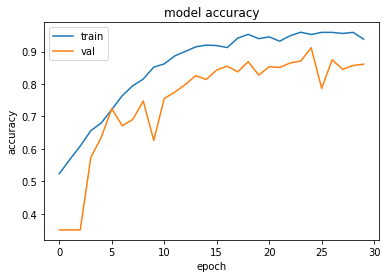

In [14]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()